### Machine Learning Engineer Nanodegree

# Capstone Project

## Telstra Network Disruptions Project

## Notebook 3:  Numeric encoding

This is a project to build a model that predict a level of fault severity at a time and a location in thier network using log data.

The dataset for this project originally came from Kaggle's past competition page:

[Telstra Network Disruptions in Kaggle](https://www.kaggle.com/c/telstra-recruiting-network)


In this notebook, I preprocess data, train models, apply refinements, and evaluate the result.

In [1]:
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

# helper module for this project
from telstra_helper import getint, read_tables

%matplotlib inline

In [2]:
# set display option to show all columns
pd.options.display.max_columns=None

## 1. Read data 

Read csv files and load data into Pandas DataFrame.

In [3]:
files = read_tables()

data_main = files['train.csv']
log_feature = files['log_feature.csv']
severity_type = files['severity_type.csv']
event_type = files['event_type.csv']
resource_type = files['resource_type.csv']


----- train.csv -----


,id,location,fault_severity
0,14121,location 118,1
1,9320,location 91,0
2,14394,location 152,1
3,8218,location 931,1
4,14804,location 120,0


id                 int64
location          object
fault_severity     int64
dtype: object


----- log_feature.csv -----


,id,log_feature,volume
0,6597,feature 68,6
1,8011,feature 68,7
2,2597,feature 68,1
3,5022,feature 172,2
4,5022,feature 56,1


id              int64
log_feature    object
volume          int64
dtype: object


----- severity_type.csv -----


,id,severity_type
0,6597,severity_type 2
1,8011,severity_type 2
2,2597,severity_type 2
3,5022,severity_type 1
4,6852,severity_type 1


id                int64
severity_type    object
dtype: object


----- event_type.csv -----

event_type.csv :Number of wrong rows = 1, positions = [31171]



,id,event_type,event_flag
1,6597,event_type 11,NaN
2,8011,event_type 15,NaN
3,2597,event_type 15,NaN
4,5022,event_type 15,NaN
5,5022,event_type 11,NaN


id              int64
event_type     object
event_flag    float64
dtype: object


----- resource_type.csv -----

resource_type.csv: Number of wrong rows = 1, positions = [21077]



,id,resource_type,resource_flag
1,6597,resource_type 8,NaN
2,8011,resource_type 8,NaN
3,2597,resource_type 8,NaN
4,5022,resource_type 8,NaN
5,6852,resource_type 8,NaN


id                 int64
resource_type     object
resource_flag    float64
dtype: object

## 2. concatenate tables

I will shape input data like this:

```

  id  |  location  fs  | st | rt1 ... rt10 | et1 ... et20 | lf1 ... lf20  vol1 ... vol20 |
 -----+----------------+----+--------------+--------------+------------------------------+
      |    int     int | int| int ... int  | int ... int  | int ...  int   int ...  int  |
```

This is based on the possible muximum number of same features assigned to one id:

  - severity_type = 1
  - resource_type = 10 (including duplicate types)
  - event_type = 20 (including duplicate types)
  - log_feature-volume = 20
   

### 2-1. Get necessary information about features

Check how many feature types for an id at maximum.

In [4]:
print("Maximum number of log_features for an id : {}".format(log_feature.groupby('id').size().max()))
print("Maximum number of event_types for an id : {}".format(event_type.groupby('id').size().max()))
print("Maximum number of resource_types for an id : {}".format(resource_type.groupby('id').size().max()))
print("Maximum number of severity_types for an id : {}".format(severity_type.groupby('id').size().max()))

Maximum number of log_features for an id : 20
Maximum number of event_types for an id : 20
Maximum number of resource_types for an id : 10
Maximum number of severity_types for an id : 1


Check the range of feature numbers.

In [5]:
# What is the range of No. of features?
et_no = event_type['event_type'].apply(getint)
print("No. of event_type: Max = {}, Min = {}".format(np.amax(et_no), np.amin(et_no)))
rt_no = resource_type['resource_type'].apply(getint)
print("No. of resource_type: Max = {}, Min = {}".format(np.amax(rt_no), np.amin(rt_no)))
lf_no = log_feature['log_feature'].apply(getint)
print("No. of log_feature: Max = {}, Min = {}".format(np.amax(lf_no), np.amin(lf_no)))
st_no = severity_type['severity_type'].apply(getint)
print("No. of severity_type: Max = {}, Min = {}".format(np.amax(st_no), np.amin(st_no)))

No. of event_type: Max = 54, Min = 1
No. of resource_type: Max = 10, Min = 1
No. of log_feature: Max = 386, Min = 1
No. of severity_type: Max = 5, Min = 1


From above output, I can know that every feature has a number that is more than 0.

(There is no features such as "event_type **0**" )

So I decided that I fill up the empty cells (no features in there) with 0.

### 2-2. Making a table

log_feature & volume, event_type, and resource_type have multiple feature members for one id. Place all members in one row holizontally.

In [6]:
def feature_in_row(feature, col_num, keyword):
    """ Output a DataFrame of rows(id) x columns(members of the feature).
        The number of columns of the new DataFrame is equal to col_num.
        feature: DataFrame of the feature
    """
    
    if feature[keyword].dtypes == 'object':
        feature[keyword] = feature[keyword].apply(getint)
    
    gp_d = feature.groupby(['id']).groups
    d = {}
    for i in feature['id'].unique():
        d[i] = np.append(feature.loc[gp_d[i]][keyword].values, np.zeros(col_num-len(gp_d[i]), dtype=int))
  
    new_df = pd.DataFrame(d).T
    new_df.columns=['{}-{}'.format(keyword, i+1) for i in range(new_df.shape[1])]
    new_df.insert(0, 'id', new_df.index)
    return new_df
 

In [7]:
# Main data
tb = data_main.copy()

# Log Feature
flat_lf = feature_in_row(log_feature, 20, 'log_feature')
tb = tb.join(flat_lf.set_index('id'), on='id')
# Volume
flat_vol = feature_in_row(log_feature, 20, 'volume')
tb = tb.join(flat_vol.set_index('id'), on='id')
print("log_feature finished!")

# Severity Type
tb = tb.join(severity_type.set_index('id'), on='id')
print("severity_type finished!")

# Event type
flat_et = feature_in_row(event_type, 20, 'event_type')
tb = tb.join(flat_et.set_index('id'), on='id')
print("event_type finished!")

# Resource type
flat_rt = feature_in_row(resource_type, 10, 'resource_type')
tb = tb.join(flat_rt.set_index('id'), on='id')
print("resource_type finished!")


display(tb.sort_values('id').head(5))
print("Total samples : {}".format(tb.shape[0]))
print("Total columns : {}".format(tb.shape[1]))


log_feature finished!
severity_type finished!
event_type finished!
resource_type finished!


,id,location,fault_severity,log_feature-1,log_feature-2,log_feature-3,log_feature-4,log_feature-5,log_feature-6,log_feature-7,log_feature-8,log_feature-9,log_feature-10,log_feature-11,log_feature-12,log_feature-13,log_feature-14,log_feature-15,log_feature-16,log_feature-17,log_feature-18,log_feature-19,log_feature-20,volume-1,volume-2,volume-3,volume-4,volume-5,volume-6,volume-7,volume-8,volume-9,volume-10,volume-11,volume-12,volume-13,volume-14,volume-15,volume-16,volume-17,volume-18,volume-19,volume-20,severity_type,event_type-1,event_type-2,event_type-3,event_type-4,event_type-5,event_type-6,event_type-7,event_type-8,event_type-9,event_type-10,event_type-11,event_type-12,event_type-13,event_type-14,event_type-15,event_type-16,event_type-17,event_type-18,event_type-19,event_type-20,resource_type-1,resource_type-2,resource_type-3,resource_type-4,resource_type-5,resource_type-6,resource_type-7,resource_type-8,resource_type-9,resource_type-10
4407,1,location 601,1,68,345,179,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,severity_type 1,11,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,6,0,0,0,0,0,0,0,0
5694,5,location 460,0,312,232,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,severity_type 2,34,35,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0
279,6,location 332,1,227,232,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,severity_type 2,34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0
4370,8,location 243,0,232,309,229,314,312,234,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,5,3,1,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,severity_type 2,34,35,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0
2199,13,location 418,0,232,312,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,severity_type 2,35,34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0


Total samples : 7381
Total columns : 74


### 2-3 Data Transformation

All string values are converted into integer.

Example) ```'severity_type 8' ---> int(8)```

In [8]:
for c in tb.columns:
    if tb[c].dtypes == 'object':
        tb[c] = tb[c].apply(getint)

display(tb.head())


,id,location,fault_severity,log_feature-1,log_feature-2,log_feature-3,log_feature-4,log_feature-5,log_feature-6,log_feature-7,log_feature-8,log_feature-9,log_feature-10,log_feature-11,log_feature-12,log_feature-13,log_feature-14,log_feature-15,log_feature-16,log_feature-17,log_feature-18,log_feature-19,log_feature-20,volume-1,volume-2,volume-3,volume-4,volume-5,volume-6,volume-7,volume-8,volume-9,volume-10,volume-11,volume-12,volume-13,volume-14,volume-15,volume-16,volume-17,volume-18,volume-19,volume-20,severity_type,event_type-1,event_type-2,event_type-3,event_type-4,event_type-5,event_type-6,event_type-7,event_type-8,event_type-9,event_type-10,event_type-11,event_type-12,event_type-13,event_type-14,event_type-15,event_type-16,event_type-17,event_type-18,event_type-19,event_type-20,resource_type-1,resource_type-2,resource_type-3,resource_type-4,resource_type-5,resource_type-6,resource_type-7,resource_type-8,resource_type-9,resource_type-10
0,14121,118,1,312,232,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,34,35,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0
1,9320,91,0,315,235,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,200,116,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,34,35,34,35,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0
2,14394,152,1,221,301,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,35,34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0
3,8218,931,1,80,82,203,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,12,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,15,11,15,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,8,0,0,0,0,0,0,0,0
4,14804,120,0,134,219,117,227,237,232,181,160,29,0,0,0,0,0,0,0,0,0,0,0,1,1,1,2,2,2,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,34,11,36,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,8,0,0,0,0,0,0,0,0


### 2-4 Make training data and testing data

In [9]:
from sklearn.model_selection import train_test_split

# Delete id and fault severity from features 
X = tb.drop(labels=['id', 'fault_severity'], axis=1)
# Make an array of fault severity
y = tb['fault_severity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)

print("There are {} training samples.".format(X_train.shape[0]))
print("There are {} testing samples.".format(X_test.shape[0]))

There are 5904 training samples.
There are 1477 testing samples.


## 3. Training a benchmark model

**NOTE: Confusion Matrix**

```
  [ x  x  x ]  <--- true class 0
  [ x  x  x ]  <--- true class 1
  [ x  x  x ]  <--- true class 2
  
```

   ```true class 0 [0]``` = predicted as 0 in true class 0   
   ```true class 0 [1]``` = predicted as 1 in true class 0   
   ```true class 0 [2]``` = predicted as 2 in true class 0    
   
and so on.


**NOTE:**

About normalization of confusion matrix, see [this link in sklearn](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py)


In [10]:
from telstra_helper import logloss_confmat

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=45, verbose=0, warm_start=False)

***** training *****
 log loss for train = 0.14442941512002128
 --- confusion matrix ---
[[3804    0    0]
 [   0 1523    0]
 [   0    0  577]]

***** testing *****
 log loss for test = 0.7211845040330843
 --- confusion matrix ---
[[855  94  31]
 [164 162  22]
 [ 44  24  81]]


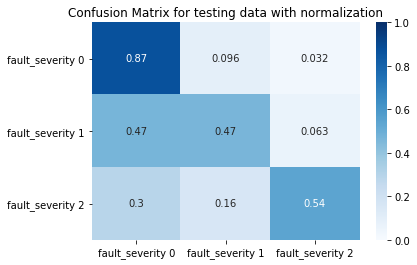

In [11]:
from sklearn.ensemble import RandomForestClassifier

# train benchmark model
benchmark_model = RandomForestClassifier(n_estimators=100, random_state=45)
print(benchmark_model)

benchmark_model.fit(X_train, y_train)

# evaluate the model by log loss and confusion matrix
benchmark_result = logloss_confmat(benchmark_model, X_train, y_train, X_test, y_test, savefile='benchmark_numeric')

**Experiment note:**

This model cannot classify data properly especially with respect to the class 'fault severity 1'. 

## 4. Train my models

Benchmark model does not seem to handle implanaced class problem properly. Some algorithms have a hyperparameter called 'class_weight' to deal with imbalanced classes, and from those algorithms I will examine these listed below:

 - Random forest
 - LightGBM
 
Hyperparameters will be tuned.

In [12]:
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

### 4-1. Random Forest (with parameter tuning)

In [13]:
param_rf = {'max_depth': [10, 20, 50],
            'min_samples_split': [5, 10, 20],
            'n_estimators': [100, 200, 300]}

# grid seach to determine optimal parameters
rf_grid = RandomForestClassifier(class_weight='balanced', random_state=45)
gs_rf = GridSearchCV(rf_grid, param_grid=param_rf, cv=4, verbose=5, scoring='neg_log_loss')
gs_rf.fit(X_train, y_train)

# see the best parameters
print(gs_rf.best_estimator_)
print(gs_rf.best_score_)


Fitting 4 folds for each of 27 candidates, totalling 108 fits
[CV] max_depth=10, min_samples_split=5, n_estimators=100 .............
[CV]  max_depth=10, min_samples_split=5, n_estimators=100, score=-0.7024691506886371, total=   0.5s
[CV] max_depth=10, min_samples_split=5, n_estimators=100 .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  max_depth=10, min_samples_split=5, n_estimators=100, score=-0.6995262531702336, total=   0.5s
[CV] max_depth=10, min_samples_split=5, n_estimators=100 .............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s


[CV]  max_depth=10, min_samples_split=5, n_estimators=100, score=-0.7103706950347924, total=   0.6s
[CV] max_depth=10, min_samples_split=5, n_estimators=100 .............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.1s remaining:    0.0s


[CV]  max_depth=10, min_samples_split=5, n_estimators=100, score=-0.6960683681516847, total=   0.5s
[CV] max_depth=10, min_samples_split=5, n_estimators=200 .............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.7s remaining:    0.0s


[CV]  max_depth=10, min_samples_split=5, n_estimators=200, score=-0.7017097507406739, total=   1.0s
[CV] max_depth=10, min_samples_split=5, n_estimators=200 .............
[CV]  max_depth=10, min_samples_split=5, n_estimators=200, score=-0.7008806710777744, total=   1.0s
[CV] max_depth=10, min_samples_split=5, n_estimators=200 .............
[CV]  max_depth=10, min_samples_split=5, n_estimators=200, score=-0.7101772352266368, total=   1.0s
[CV] max_depth=10, min_samples_split=5, n_estimators=200 .............
[CV]  max_depth=10, min_samples_split=5, n_estimators=200, score=-0.6920331130564304, total=   1.0s
[CV] max_depth=10, min_samples_split=5, n_estimators=300 .............
[CV]  max_depth=10, min_samples_split=5, n_estimators=300, score=-0.7013507900070907, total=   1.6s
[CV] max_depth=10, min_samples_split=5, n_estimators=300 .............
[CV]  max_depth=10, min_samples_split=5, n_estimators=300, score=-0.6998374611319241, total=   1.6s
[CV] max_depth=10, min_samples_split=5, n_est

[CV]  max_depth=20, min_samples_split=10, n_estimators=200, score=-0.6066471867198749, total=   1.3s
[CV] max_depth=20, min_samples_split=10, n_estimators=200 ............
[CV]  max_depth=20, min_samples_split=10, n_estimators=200, score=-0.626587387588136, total=   1.3s
[CV] max_depth=20, min_samples_split=10, n_estimators=200 ............
[CV]  max_depth=20, min_samples_split=10, n_estimators=200, score=-0.628929288522949, total=   1.2s
[CV] max_depth=20, min_samples_split=10, n_estimators=200 ............
[CV]  max_depth=20, min_samples_split=10, n_estimators=200, score=-0.618334227223004, total=   1.2s
[CV] max_depth=20, min_samples_split=10, n_estimators=300 ............
[CV]  max_depth=20, min_samples_split=10, n_estimators=300, score=-0.6066564360585024, total=   1.9s
[CV] max_depth=20, min_samples_split=10, n_estimators=300 ............
[CV]  max_depth=20, min_samples_split=10, n_estimators=300, score=-0.6271314928745508, total=   1.9s
[CV] max_depth=20, min_samples_split=10, n

[CV]  max_depth=50, min_samples_split=20, n_estimators=200, score=-0.6349187500717938, total=   1.1s
[CV] max_depth=50, min_samples_split=20, n_estimators=200 ............
[CV]  max_depth=50, min_samples_split=20, n_estimators=200, score=-0.6485480557048305, total=   1.2s
[CV] max_depth=50, min_samples_split=20, n_estimators=200 ............
[CV]  max_depth=50, min_samples_split=20, n_estimators=200, score=-0.6484736505049762, total=   1.1s
[CV] max_depth=50, min_samples_split=20, n_estimators=200 ............
[CV]  max_depth=50, min_samples_split=20, n_estimators=200, score=-0.6367636331075593, total=   1.2s
[CV] max_depth=50, min_samples_split=20, n_estimators=300 ............
[CV]  max_depth=50, min_samples_split=20, n_estimators=300, score=-0.6337421328913185, total=   1.8s
[CV] max_depth=50, min_samples_split=20, n_estimators=300 ............
[CV]  max_depth=50, min_samples_split=20, n_estimators=300, score=-0.6481972586654555, total=   1.7s
[CV] max_depth=50, min_samples_split=20

[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:  2.7min finished


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=20, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=1, oob_score=False, random_state=45,
            verbose=0, warm_start=False)
-0.6033923575034675



***** training *****
 log loss for train = 0.3218053864542099
 --- confusion matrix ---
[[3486  209  109]
 [  54 1426   43]
 [   1    1  575]]

***** testing *****
 log loss for test = 0.5707657931136978
 --- confusion matrix ---
[[793 137  50]
 [ 98 215  35]
 [ 21  19 109]]


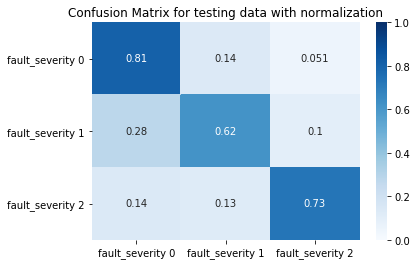

In [14]:
# train the model with the best parameters
rf_clf_best = RandomForestClassifier(n_estimators=300, max_depth=20, min_samples_split=5, \
                                       class_weight='balanced', random_state=45)
rf_clf_best.fit(X_train, y_train)

# predict labels and evaluate the result
rf_result = logloss_confmat(rf_clf_best, X_train, y_train, X_test, y_test, savefile='rf_best_numeric')


### 4-2. LightGBM

**Install:**

```> pip install lightgbm ```

**installed version:**

2.2.2

**Document for parameters:**

[LightGBM sickit-learn API](https://lightgbm.readthedocs.io/en/latest/Python-API.html#scikit-learn-api)

About Parameter Tuning, see [this page](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html)

Some important parameters are:

- ```num_leaves```:  This is the main parameter to control the complexity of the tree model. Should be smaller than 2^(max_depth)
- ```min_data_in_leaf```: This is a very important parameter to prevent over-fitting in a leaf-wise tree. Large value can avoid growing too deep a tree, but may cause underfitting. Hundreds or thousands is enough for a large dataset.
 
- ```max_bin```: large value for better accuracy

In [15]:
param_lgb = {"min_data_in_leaf": [6, 7, 8], 
             "num_leaves": [45, 50, 55],
             # "feature_fraction": [1, 0.8, 0.5]
             "feature_fraction": [0.5]
              }

# grid seach to determine optimal parameters
lgb_clf_grid = lgb.LGBMClassifier(max_bin=512, class_weight='balanced')
gs_lgb = GridSearchCV(lgb_clf_grid, param_grid=param_lgb, cv=4, verbose=5, scoring='neg_log_loss')
gs_lgb.fit(X_train, y_train)

# see the best parameters
print(gs_lgb.best_estimator_)
print(gs_lgb.best_score_)

Fitting 4 folds for each of 9 candidates, totalling 36 fits
[CV] feature_fraction=0.5, min_data_in_leaf=6, num_leaves=45 .........
[CV]  feature_fraction=0.5, min_data_in_leaf=6, num_leaves=45, score=-0.5997610719849429, total=   1.1s
[CV] feature_fraction=0.5, min_data_in_leaf=6, num_leaves=45 .........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV]  feature_fraction=0.5, min_data_in_leaf=6, num_leaves=45, score=-0.6174105332900897, total=   0.9s
[CV] feature_fraction=0.5, min_data_in_leaf=6, num_leaves=45 .........


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s


[CV]  feature_fraction=0.5, min_data_in_leaf=6, num_leaves=45, score=-0.623575812140156, total=   4.8s
[CV] feature_fraction=0.5, min_data_in_leaf=6, num_leaves=45 .........


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.5s remaining:    0.0s


[CV]  feature_fraction=0.5, min_data_in_leaf=6, num_leaves=45, score=-0.5925252094972585, total=   0.9s
[CV] feature_fraction=0.5, min_data_in_leaf=6, num_leaves=50 .........


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    8.6s remaining:    0.0s


[CV]  feature_fraction=0.5, min_data_in_leaf=6, num_leaves=50, score=-0.6024591893267979, total=   1.9s
[CV] feature_fraction=0.5, min_data_in_leaf=6, num_leaves=50 .........
[CV]  feature_fraction=0.5, min_data_in_leaf=6, num_leaves=50, score=-0.6136329846952793, total=   1.7s
[CV] feature_fraction=0.5, min_data_in_leaf=6, num_leaves=50 .........
[CV]  feature_fraction=0.5, min_data_in_leaf=6, num_leaves=50, score=-0.6201692298285453, total=   1.0s
[CV] feature_fraction=0.5, min_data_in_leaf=6, num_leaves=50 .........
[CV]  feature_fraction=0.5, min_data_in_leaf=6, num_leaves=50, score=-0.5969547944653013, total=   1.0s
[CV] feature_fraction=0.5, min_data_in_leaf=6, num_leaves=55 .........
[CV]  feature_fraction=0.5, min_data_in_leaf=6, num_leaves=55, score=-0.5966356855073844, total=   5.7s
[CV] feature_fraction=0.5, min_data_in_leaf=6, num_leaves=55 .........
[CV]  feature_fraction=0.5, min_data_in_leaf=6, num_leaves=55, score=-0.6155413827105424, total=   3.4s
[CV] feature_fraction

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  1.3min finished


LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=1.0, feature_fraction=0.5,
        importance_type='split', learning_rate=0.1, max_bin=512,
        max_depth=-1, min_child_samples=20, min_child_weight=0.001,
        min_data_in_leaf=6, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=55, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)
-0.6058536360288688


C:\Users\Chieko\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Chieko\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



***** training *****
 log loss for train = 0.31653211244323
 --- confusion matrix ---
[[3221  443  140]
 [  62 1424   37]
 [   1    0  576]]

***** testing *****
 log loss for test = 0.5729767164010361
 --- confusion matrix ---
[[758 165  57]
 [ 67 243  38]
 [ 12  23 114]]


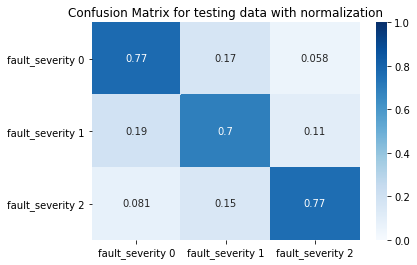

In [16]:
# train the model with the best parameters
lgb_best_clf = lgb.LGBMClassifier(feature_fraction=0.5, min_data_in_leaf=6, num_leaves=55, \
                                  max_bin=512, class_weight='balanced', random_state=45)

lgb_best_clf.fit(X_train, y_train)

# predict labels and evaluate the result
lgb_result = logloss_confmat(lgb_best_clf, X_train, y_train, X_test, y_test, savefile="lgb_best_numeric")

**Experiment note:**

LightGBM seems to be good for this problem. A remarkable thing is that, although log_loss value for test is almost the same as Random Forest model, I think this model is quite better than the Random Forest model referring to the confusion matrix.

# 4. Refinement

## 1) Manually specifing class weights

For LightBGM model, I will tune the class_weight for further refinement.

According to [LightGBM document](https://lightgbm.readthedocs.io/en/latest/Python-API.html), setting ```class_weight = 'balanced'``` means ```n_samples / (n_classes * np.bincount(y))```.

So the actual class weights can be obtained by this formula.


In [17]:
# calculate default class weights
def_classweight = X_train.shape[0] / (3 * np.bincount(y_train))
print(def_classweight)

# obtain class weights by a ratio 
print(def_classweight / def_classweight[0])

[0.51735016 1.29218647 3.41074523]
[1.         2.4977019  6.59272097]


C:\Users\Chieko\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Chieko\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



***** training *****
 log loss for train = 0.32656885866900515
 --- confusion matrix ---
[[3148  507  149]
 [  46 1441   36]
 [   1    0  576]]

***** testing *****
 log loss for test = 0.5815540002247438
 --- confusion matrix ---
[[734 185  61]
 [ 58 252  38]
 [ 11  22 116]]


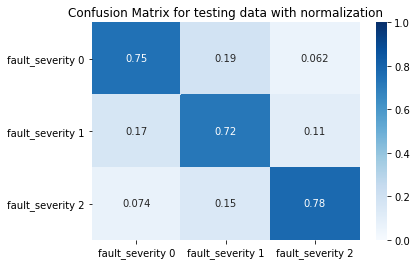

In [18]:
# set class weight manually
class_weight = { 0: 1, 1: 2.8, 2: 8}

# train the model with parameters
lgb_cw_clf = lgb.LGBMClassifier(feature_fraction=0.5, min_data_in_leaf=6, num_leaves=55, \
                                  max_bin=512, class_weight=class_weight, random_state=45)

lgb_cw_clf.fit(X_train, y_train)

# predict labels and evaluate the result
lgb_cw_result = logloss_confmat(lgb_cw_clf, X_train, y_train, X_test, y_test, savefile='lgb_cw_numeric')

## 2) Feature Importance

See which feature has higher feature importance in LightGBM.

In [19]:
from telstra_helper import print_fi

# print feature importance of the LightGBM model
print("*** LightGBM  (class_weight='balanced')  ***")
print_fi(lgb_best_clf.feature_importances_, X_train.columns)


*** LightGBM  (class_weight='balanced')  ***
FEATURE: FI VALUE, PERCENT (CUMULATIVE VALUE [PERCENT]) 
--------------------------------------------------
(1) location: 2763, 17.06% (2763 [17.06%])
(2) log_feature-1: 1631, 10.07% (4394 [27.12%])
(3) log_feature-2: 1460, 9.01% (5854 [36.14%])
(4) volume-2: 1359, 8.39% (7213 [44.52%])
(5) volume-1: 1183, 7.30% (8396 [51.83%])
(6) volume-3: 958, 5.91% (9354 [57.74%])
(7) log_feature-3: 923, 5.70% (10277 [63.44%])
(8) log_feature-4: 782, 4.83% (11059 [68.27%])
(9) volume-4: 694, 4.28% (11753 [72.55%])
(10) event_type-1: 595, 3.67% (12348 [76.22%])
(11) event_type-2: 513, 3.17% (12861 [79.39%])
(12) log_feature-5: 454, 2.80% (13315 [82.19%])
(13) severity_type: 344, 2.12% (13659 [84.31%])
(14) resource_type-2: 332, 2.05% (13991 [86.36%])
(15) volume-5: 313, 1.93% (14304 [88.30%])
(16) log_feature-6: 286, 1.77% (14590 [90.06%])
(17) event_type-3: 286, 1.77% (14876 [91.83%])
(18) resource_type-1: 259, 1.60% (15135 [93.43%])
(19) volume-6: 233, 

It seems features are important in the order below:

1. location
2. log_feature
3. volume
4. event_type
5. severity_type

In [20]:
# select columns
high_fi = ['location', 'log_feature-1', 'log_feature-2', 'log_feature-3', 'log_feature-4', 'log_feature-5',\
           'volume-1', 'volume-2', 'volume-3', 'volume-4', 'volume-5', 'volume-6', \
           'severity_type']

# extract only important features and remake input data
X_train_fi = X_train.loc[:, high_fi]
display(X_train_fi.head())

X_test_fi = X_test.loc[:, high_fi]
display(X_test_fi.head())

,location,log_feature-1,log_feature-2,log_feature-3,log_feature-4,log_feature-5,volume-1,volume-2,volume-3,volume-4,volume-5,volume-6,severity_type
6629,538,171,55,0,0,0,2,2,0,0,0,0,1
3381,1061,80,82,201,0,0,4,16,1,0,0,0,2
2845,155,312,232,0,0,0,14,11,0,0,0,0,2
1516,738,63,183,0,0,0,1,1,0,0,0,0,2
5741,854,170,54,0,0,0,4,3,0,0,0,0,1


,location,log_feature-1,log_feature-2,log_feature-3,log_feature-4,log_feature-5,volume-1,volume-2,volume-3,volume-4,volume-5,volume-6,severity_type
6029,370,313,315,308,310,0,2,2,1,1,0,0,4
2282,1100,71,82,203,0,0,2,42,13,0,0,0,1
5699,807,279,0,0,0,0,1,0,0,0,0,0,4
2949,149,312,232,307,233,313,3,2,2,2,2,0,2
3020,1072,81,0,0,0,0,1,0,0,0,0,0,2


### Grid Search

In [21]:
param_lgb2 = {#"min_data_in_leaf": [1], 
             "num_leaves": [20, 55, 70, 100],
             # "feature_fraction": [1, 0.8, 0.5]
             "feature_fraction": [0.5],
             "n_estimators": [20, 50, 70, 100],
             "min_data_in_leaf": [6, 7, 8]}

# grid seach to determine optimal parameters
lgb_clf2_grid = lgb.LGBMClassifier(max_bin=512, class_weight='balanced')
gs_lgb2 = GridSearchCV(lgb_clf2_grid, param_grid=param_lgb2, cv=4, verbose=5, scoring='neg_log_loss')
gs_lgb2.fit(X_train_fi, y_train)

# see the best parameters
print(gs_lgb2.best_estimator_)
print(gs_lgb2.best_score_)

Fitting 4 folds for each of 48 candidates, totalling 192 fits
[CV] feature_fraction=0.5, min_data_in_leaf=6, n_estimators=20, num_leaves=20 
[CV]  feature_fraction=0.5, min_data_in_leaf=6, n_estimators=20, num_leaves=20, score=-0.7711520340793472, total=   0.2s
[CV] feature_fraction=0.5, min_data_in_leaf=6, n_estimators=20, num_leaves=20 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  feature_fraction=0.5, min_data_in_leaf=6, n_estimators=20, num_leaves=20, score=-0.7681088313233722, total=   0.0s
[CV] feature_fraction=0.5, min_data_in_leaf=6, n_estimators=20, num_leaves=20 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


[CV]  feature_fraction=0.5, min_data_in_leaf=6, n_estimators=20, num_leaves=20, score=-0.777467051906898, total=   0.5s
[CV] feature_fraction=0.5, min_data_in_leaf=6, n_estimators=20, num_leaves=20 
[CV]  feature_fraction=0.5, min_data_in_leaf=6, n_estimators=20, num_leaves=20, score=-0.7606911541709666, total=   0.0s
[CV] feature_fraction=0.5, min_data_in_leaf=6, n_estimators=20, num_leaves=55 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.2s remaining:    0.0s


[CV]  feature_fraction=0.5, min_data_in_leaf=6, n_estimators=20, num_leaves=55, score=-0.7286705816604919, total=   0.1s
[CV] feature_fraction=0.5, min_data_in_leaf=6, n_estimators=20, num_leaves=55 
[CV]  feature_fraction=0.5, min_data_in_leaf=6, n_estimators=20, num_leaves=55, score=-0.7297257025336933, total=   0.1s
[CV] feature_fraction=0.5, min_data_in_leaf=6, n_estimators=20, num_leaves=55 
[CV]  feature_fraction=0.5, min_data_in_leaf=6, n_estimators=20, num_leaves=55, score=-0.730143951435738, total=   0.1s
[CV] feature_fraction=0.5, min_data_in_leaf=6, n_estimators=20, num_leaves=55 
[CV]  feature_fraction=0.5, min_data_in_leaf=6, n_estimators=20, num_leaves=55, score=-0.7182329659327109, total=   0.1s
[CV] feature_fraction=0.5, min_data_in_leaf=6, n_estimators=20, num_leaves=70 
[CV]  feature_fraction=0.5, min_data_in_leaf=6, n_estimators=20, num_leaves=70, score=-0.7170544140319747, total=   0.2s
[CV] feature_fraction=0.5, min_data_in_leaf=6, n_estimators=20, num_leaves=70 
[

[CV]  feature_fraction=0.5, min_data_in_leaf=6, n_estimators=70, num_leaves=100, score=-0.6323345917626134, total=   1.3s
[CV] feature_fraction=0.5, min_data_in_leaf=6, n_estimators=70, num_leaves=100 
[CV]  feature_fraction=0.5, min_data_in_leaf=6, n_estimators=70, num_leaves=100, score=-0.6168937587536779, total=   1.9s
[CV] feature_fraction=0.5, min_data_in_leaf=6, n_estimators=70, num_leaves=100 
[CV]  feature_fraction=0.5, min_data_in_leaf=6, n_estimators=70, num_leaves=100, score=-0.5976151125842535, total=   1.4s
[CV] feature_fraction=0.5, min_data_in_leaf=6, n_estimators=100, num_leaves=20 
[CV]  feature_fraction=0.5, min_data_in_leaf=6, n_estimators=100, num_leaves=20, score=-0.6458612007222349, total=   0.7s
[CV] feature_fraction=0.5, min_data_in_leaf=6, n_estimators=100, num_leaves=20 
[CV]  feature_fraction=0.5, min_data_in_leaf=6, n_estimators=100, num_leaves=20, score=-0.6560712000482735, total=   0.4s
[CV] feature_fraction=0.5, min_data_in_leaf=6, n_estimators=100, num_l

[CV]  feature_fraction=0.5, min_data_in_leaf=7, n_estimators=50, num_leaves=55, score=-0.6402436726416811, total=   0.9s
[CV] feature_fraction=0.5, min_data_in_leaf=7, n_estimators=50, num_leaves=55 
[CV]  feature_fraction=0.5, min_data_in_leaf=7, n_estimators=50, num_leaves=55, score=-0.6223540739260742, total=   1.2s
[CV] feature_fraction=0.5, min_data_in_leaf=7, n_estimators=50, num_leaves=70 
[CV]  feature_fraction=0.5, min_data_in_leaf=7, n_estimators=50, num_leaves=70, score=-0.6245113801402004, total=   1.1s
[CV] feature_fraction=0.5, min_data_in_leaf=7, n_estimators=50, num_leaves=70 
[CV]  feature_fraction=0.5, min_data_in_leaf=7, n_estimators=50, num_leaves=70, score=-0.6397751914392963, total=   1.0s
[CV] feature_fraction=0.5, min_data_in_leaf=7, n_estimators=50, num_leaves=70 
[CV]  feature_fraction=0.5, min_data_in_leaf=7, n_estimators=50, num_leaves=70, score=-0.6329588036924919, total=   1.0s
[CV] feature_fraction=0.5, min_data_in_leaf=7, n_estimators=50, num_leaves=70 


[CV]  feature_fraction=0.5, min_data_in_leaf=7, n_estimators=100, num_leaves=100, score=-0.6064655624353333, total=   7.6s
[CV] feature_fraction=0.5, min_data_in_leaf=8, n_estimators=20, num_leaves=20 
[CV]  feature_fraction=0.5, min_data_in_leaf=8, n_estimators=20, num_leaves=20, score=-0.7703030261979467, total=   0.2s
[CV] feature_fraction=0.5, min_data_in_leaf=8, n_estimators=20, num_leaves=20 
[CV]  feature_fraction=0.5, min_data_in_leaf=8, n_estimators=20, num_leaves=20, score=-0.7671245398231703, total=   0.2s
[CV] feature_fraction=0.5, min_data_in_leaf=8, n_estimators=20, num_leaves=20 
[CV]  feature_fraction=0.5, min_data_in_leaf=8, n_estimators=20, num_leaves=20, score=-0.7763757834857111, total=   0.2s
[CV] feature_fraction=0.5, min_data_in_leaf=8, n_estimators=20, num_leaves=20 
[CV]  feature_fraction=0.5, min_data_in_leaf=8, n_estimators=20, num_leaves=20, score=-0.7616050846411113, total=   0.2s
[CV] feature_fraction=0.5, min_data_in_leaf=8, n_estimators=20, num_leaves=55

[CV]  feature_fraction=0.5, min_data_in_leaf=8, n_estimators=70, num_leaves=70, score=-0.6044895344637451, total=   1.5s
[CV] feature_fraction=0.5, min_data_in_leaf=8, n_estimators=70, num_leaves=70 
[CV]  feature_fraction=0.5, min_data_in_leaf=8, n_estimators=70, num_leaves=70, score=-0.6345178706043051, total=   6.8s
[CV] feature_fraction=0.5, min_data_in_leaf=8, n_estimators=70, num_leaves=70 
[CV]  feature_fraction=0.5, min_data_in_leaf=8, n_estimators=70, num_leaves=70, score=-0.625324822126616, total=   1.4s
[CV] feature_fraction=0.5, min_data_in_leaf=8, n_estimators=70, num_leaves=70 
[CV]  feature_fraction=0.5, min_data_in_leaf=8, n_estimators=70, num_leaves=70, score=-0.6002392501815182, total=   2.4s
[CV] feature_fraction=0.5, min_data_in_leaf=8, n_estimators=70, num_leaves=100 
[CV]  feature_fraction=0.5, min_data_in_leaf=8, n_estimators=70, num_leaves=100, score=-0.5999684699907536, total=   1.8s
[CV] feature_fraction=0.5, min_data_in_leaf=8, n_estimators=70, num_leaves=100

[Parallel(n_jobs=1)]: Done 192 out of 192 | elapsed:  6.0min finished


LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=1.0, feature_fraction=0.5,
        importance_type='split', learning_rate=0.1, max_bin=512,
        max_depth=-1, min_child_samples=20, min_child_weight=0.001,
        min_data_in_leaf=6, min_split_gain=0.0, n_estimators=70, n_jobs=-1,
        num_leaves=100, objective=None, random_state=None, reg_alpha=0.0,
        reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)
-0.6105673363191005


C:\Users\Chieko\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Chieko\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



***** training *****
 log loss for train = 0.3007651540072421
 --- confusion matrix ---
[[3275  403  126]
 [  47 1443   33]
 [   0    0  577]]

***** testing *****
 log loss for test = 0.565498863469068
 --- confusion matrix ---
[[752 170  58]
 [ 70 236  42]
 [ 15  18 116]]


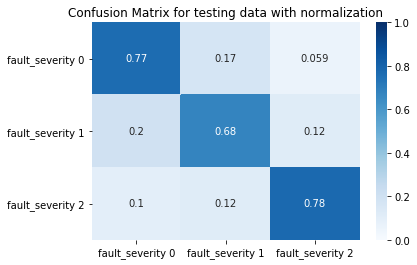

In [22]:
# train the model with the best parameters
lgb_best_clf_fi = lgb.LGBMClassifier(feature_fraction=0.5, num_leaves=100, min_data_in_leaf=6,\
                                  n_estimators=70, max_bin=512, class_weight='balanced', random_state=45)

# input data with feature selection
lgb_best_clf_fi.fit(X_train_fi, y_train)

# predict labels and evaluate the result
lgb_fi_result = logloss_confmat(lgb_best_clf_fi, X_train_fi, y_train, X_test_fi, y_test, savefile='lgb_fi_numeric')

## 3) class weight x feature importance

I tried this, but it did not show an improvement. **I did not include this model in the report.**

C:\Users\Chieko\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Chieko\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



***** training *****
 log loss for train = 0.31163812625631043
 --- confusion matrix ---
[[3204  468  132]
 [  39 1457   27]
 [   0    0  577]]

***** testing *****
 log loss for test = 0.5764250549156203
 --- confusion matrix ---
[[734 187  59]
 [ 63 248  37]
 [ 13  25 111]]


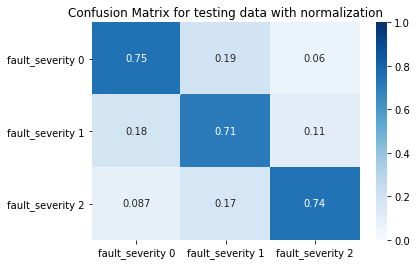

{'log_loss': [0.31163812625631043, 0.5764250549156203],
 'conf_mat': [array([[3204,  468,  132],
         [  39, 1457,   27],
         [   0,    0,  577]], dtype=int64), array([[734, 187,  59],
         [ 63, 248,  37],
         [ 13,  25, 111]], dtype=int64)]}

In [23]:
# set class weight manually
classweight_fi = { 0: 1, 1: 3, 2: 7}

# obtain a classifier with parameters
lgb_best_clf_fi = lgb.LGBMClassifier(feature_fraction=0.5, num_leaves=100, min_data_in_leaf=6,\
                                  n_estimators=70, max_bin=512, class_weight=classweight_fi, random_state=45)

# input data with feature selection
lgb_best_clf_fi.fit(X_train_fi, y_train)

# predict labels and evaluate the result
logloss_confmat(lgb_best_clf_fi, X_train_fi, y_train, X_test_fi, y_test)

# 5. Test with unseen data

Test the best model (LightGBM) with the data in `test.csv`.

This data has no label, so I cannot check the prediction precisely. I would like to see the proportion of predicted classes.


In [24]:
# prediction of the test data
pred = lgb_best_clf.predict(X_test)

# See how many samples were sorted into each class
c_fs0 = np.count_nonzero(pred == 0)
c_fs1 = np.count_nonzero(pred == 1) 
c_fs2 = np.count_nonzero(pred == 2)
print("The number of fs 0 = {} ({:2.2%})".format(c_fs0, c_fs0/len(pred)))
print("The number of fs 1 = {} ({:2.2%})".format(c_fs1, c_fs1/len(pred)))
print("The number of fs 2 = {} ({:2.2%})".format(c_fs2, c_fs2/len(pred)))

The number of fs 0 = 837 (56.67%)
The number of fs 1 = 431 (29.18%)
The number of fs 2 = 209 (14.15%)


C:\Users\Chieko\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Load `test.csv` and assemble an input table.

In [25]:
# Test data
data_test = pd.read_csv("data/test.csv")
print("The number of id in the new data = {}".format(len(data_test['id'].unique())))

The number of id in the new data = 11171


In [26]:
# Combine features into a table
tb_test = data_test.copy()

# Log Feature
test_lf = feature_in_row(log_feature, 20, 'log_feature')
tb_test = tb_test.join(test_lf.set_index('id'), on='id')
# Volume
test_vol = feature_in_row(log_feature, 20, 'volume')
tb_test = tb_test.join(test_vol.set_index('id'), on='id')
print("log_feature finished!")

# Severity Type
tb_test = tb_test.join(severity_type.set_index('id'), on='id')
print("severity_type finished!")

# Event type
test_et = feature_in_row(event_type, 20, 'event_type')
tb_test = tb_test.join(test_et.set_index('id'), on='id')
print("event_type finished!")

# Resource type
test_rt = feature_in_row(resource_type, 10, 'resource_type')
tb_test = tb_test.join(test_rt.set_index('id'), on='id')
print("resource_type finished!")

# cast string columns to int
for c in tb_test.columns:
    if tb_test[c].dtypes == 'object':
        tb_test[c] = tb_test[c].apply(getint)

print("\n")
print("Total samples : {}".format(tb_test.shape[0]))
print("Total columns : {}".format(tb_test.shape[1]))

display(tb_test.sort_values('id').head(5))

log_feature finished!
severity_type finished!
event_type finished!
resource_type finished!


Total samples : 11171
Total columns : 73


,id,location,log_feature-1,log_feature-2,log_feature-3,log_feature-4,log_feature-5,log_feature-6,log_feature-7,log_feature-8,log_feature-9,log_feature-10,log_feature-11,log_feature-12,log_feature-13,log_feature-14,log_feature-15,log_feature-16,log_feature-17,log_feature-18,log_feature-19,log_feature-20,volume-1,volume-2,volume-3,volume-4,volume-5,volume-6,volume-7,volume-8,volume-9,volume-10,volume-11,volume-12,volume-13,volume-14,volume-15,volume-16,volume-17,volume-18,volume-19,volume-20,severity_type,event_type-1,event_type-2,event_type-3,event_type-4,event_type-5,event_type-6,event_type-7,event_type-8,event_type-9,event_type-10,event_type-11,event_type-12,event_type-13,event_type-14,event_type-15,event_type-16,event_type-17,event_type-18,event_type-19,event_type-20,resource_type-1,resource_type-2,resource_type-3,resource_type-4,resource_type-5,resource_type-6,resource_type-7,resource_type-8,resource_type-9,resource_type-10
5113,2,474,315,312,235,233,313,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,35,34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0
4193,3,64,171,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0
4829,4,645,370,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,47,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0
2371,7,638,368,283,376,291,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,44,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0
3570,9,1100,56,203,172,82,105,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,213,2,158,15,33,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,15,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0


In [27]:
# delete id from the table
new_X = tb_test.drop(labels=['id'], axis=1)

# predict the class by LightGBM model
new_pred = lgb_best_clf.predict(new_X)


C:\Users\Chieko\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [28]:
new_c_fs0 = np.count_nonzero(new_pred == 0)
new_c_fs1 = np.count_nonzero(new_pred == 1) 
new_c_fs2 = np.count_nonzero(new_pred == 2)
print("The number of fault severity 0 = {} ({:2.2%})".format(new_c_fs0, new_c_fs0/len(new_pred)))
print("The number of fault severity 1 = {} ({:2.2%})".format(new_c_fs1, new_c_fs1/len(new_pred)))
print("The number of fault severity 2 = {} ({:2.2%})".format(new_c_fs2, new_c_fs2/len(new_pred)))

The number of fault severity 0 = 5998 (53.69%)
The number of fault severity 1 = 3521 (31.52%)
The number of fault severity 2 = 1652 (14.79%)


# 6. Conclusion

## Visualization of the results

In [32]:
# Put all results from the models into a DataFrame

results_numeric = {'Benchmark_numeric' : benchmark_result,
                   'RandomForest_numeric' : rf_result,
                   'LightGBM_numeric' : lgb_result,
                   'LightGBM_cw_numeric' : lgb_cw_result,
                   'LightGBM_fs_numeric' : lgb_fi_result
                   }

result_d = {'log_loss': [], 'conf_mat_av': [], 'model': []}

for model, result in results_numeric.items():
    # store test log loss in dict
    result_d['log_loss'].append(result['log_loss'][1])
    
    # store average of correct cells of normalized confusion matrix
    conf_mat_norm = result['conf_mat'][1].astype('float') / result['conf_mat'][1].sum(axis=1)[:, np.newaxis]    
    result_d['conf_mat_av'].append(np.sum(conf_mat_norm*np.eye(3, dtype=float))/3)
    
    result_d['model'].append(model)
    
result_df = pd.DataFrame(result_d)
display(result_df)

# save the result in a file (for the later convenience)
result_df.to_csv('result_numeric.csv', index=False)

,log_loss,conf_mat_av,model
0,0.721185,0.627197,Benchmark_numeric
1,0.570766,0.719514,RandomForest_numeric
2,0.572977,0.745615,LightGBM_numeric
3,0.581554,0.750547,LightGBM_cw_numeric
4,0.565499,0.741344,LightGBM_fs_numeric


In [33]:
# read the result from the notebook for one-hot encoding version
result_onehot = pd.read_csv("result_onehot.csv")
display(result_onehot)

,log_loss,conf_mat_av,model
0,0.629027,0.612193,Benchmark_onehot
1,0.584000,0.712662,RandomForest_onehot
2,0.599362,0.738052,LightGBM_onehot
3,0.677665,0.691307,DNN_onehot


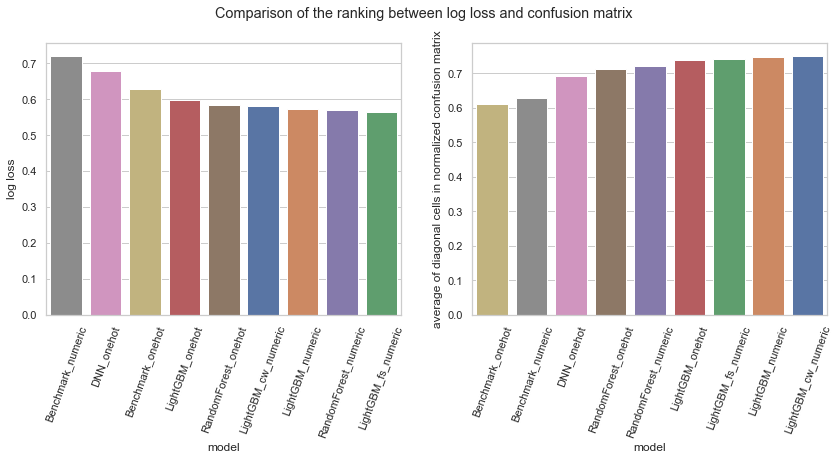

In [34]:
# sort data by the score of confusion matrix and assign colors
result_df_all = pd.concat([result_onehot, result_df], ignore_index=True)
result_confmat = result_df_all.sort_values(by=['conf_mat_av'], ascending=False).reset_index(drop=True)
result_confmat['color'] = sns.color_palette("deep", 9)
result_confmat = result_confmat[::-1]

# sort data by log loss
result_logloss = result_confmat.sort_values(by=['log_loss'], ascending=False)

# plot log loss and average of diagonal cell in confusion matrix
sns.set(style="whitegrid")
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
sns.barplot(x='model', y='log_loss', palette=result_logloss['color'], ax=ax1, data=result_logloss)
sns.barplot(x='model', y='conf_mat_av', palette=result_confmat['color'], ax=ax2, data=result_confmat)

# set axes and labels
ax1.set_xticklabels(result_logloss['model'], rotation=70)
ax2.set_xticklabels(result_confmat['model'], rotation=70)
ax1.set_ylabel("log loss")
ax2.set_ylabel("average of diagonal cells in normalized confusion matrix")
fig.suptitle("Comparison of the ranking between log loss and confusion matrix")

plt.savefig("figures/compare_metrics.png", bbox_inches='tight')
plt.show()
